# DIP HW3
#### 请同学们完成后打包整个文件夹提交到教学网，压缩包命名为“学号_姓名_HW3”

In [1]:
# 如需额外模块请自行import
%matplotlib inline
# coding = utf-8

import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
from math import sqrt
from mpl_toolkits import mplot3d
from Function import get_motion_psf
from numpy import fft

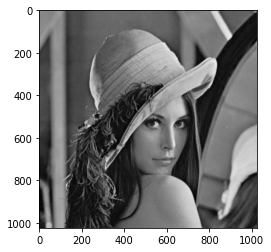

In [2]:
img = cv2.imread('lena.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap="gray")  # 注意加cmap参数
plt.show()

## Q1: 图像去噪
使用巴特沃兹低通滤波器进行图像去噪

### 1.为图像添加高斯噪声
#### （1）设置噪声均值(mean)和方差(var)<br/>

In [3]:
# TODO
mean =  0
var =  0.16

#### （2）生成噪声：<br>
可以使用np.random.normal函数<br/>

In [4]:
# TODO
def gaussian_noise(img, mean, sigma):
    '''
    mean: 均值
    sigam: 方差
    '''
    img = img/256
    noise = np.random.normal(mean, sigma, img.shape)
    noise_img = img + noise
    noise_img = np.clip(noise_img, 0, 1)
    noise_img = noise_img*256
    noise_img = np.uint8(noise_img)

    return noise_img, noise

#### （3）展示加噪图：<br>
调用plt.imshow时注意数据格式化为uint8<br/>

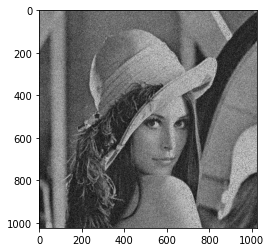

In [5]:
# TODO
noise_img, noise = gaussian_noise(img, mean, var)
plt.imshow(noise_img, cmap="gray")
plt.show()

### 2.使用巴特沃斯低通滤波器进行去噪
#### （1）将图像转换到频域：<br>
可调用np.fft.fft2函数执行傅里叶变换<br>
注意将低频部分移到中间，高频部分移到四周，可调用np.fft.fftshift函数<br>
尝试展示频域图像（提示：使用np.abs取模，取log）<br>
matplotlib对于不是uint8的图像会自动把图像的数值缩放到0-255上

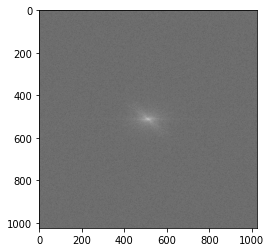

In [6]:
# TODO
fft2 = np.fft.fft2(noise_img)
shift2center = np.fft.fftshift(fft2)
log_shift2center = np.log(1+np.abs(shift2center))
plt.imshow(log_shift2center, cmap='gray')
plt.show()

#### （2）生成滤波器<br>
设置阶数n和截止频率D0<br>

In [7]:
# TODO
D0 = 40
n = 1

生成频域的巴特沃斯低通滤波器

In [8]:
# TODO
def cal_distance(pa, pb):
    return np.sqrt((pa[0]-pb[0])**2+(pa[1]-pb[1])**2)

def Butterworth_filter(D0, n, img):
    transform_matrix = np.zeros_like(img, dtype=float)
    center_point = tuple(map(lambda x:(x-1)/2, img.shape))
    for i in range(transform_matrix.shape[0]):
        for j in range(transform_matrix.shape[1]):
            dis = cal_distance(center_point, (i,j))
            # print(1.0/(1+math.pow(dis/D0, 2*n)))
            transform_matrix[i, j] = 1.0/(1+math.pow(dis/D0, 2*n))
    return transform_matrix

transform_matrix = Butterworth_filter(D0, n, noise_img)

展示滤波器三维曲面，可调用plt.axes(projection='3d')生成<br>
一个可视化对象，调用对象的方法contour3D进行绘图

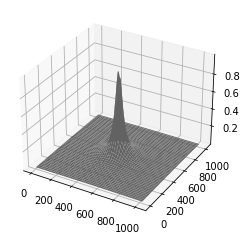

In [9]:
# TODO
axes = plt.axes(projection = '3d')
X = np.arange(0, noise_img.shape[0],1)
Y = np.arange(0, noise_img.shape[1], 1)
X, Y = np.meshgrid(X, Y)
axes.plot_surface(X, Y, transform_matrix, linewidth=0, color ='gray')
# plt.imshow(transform_matrix, cmap='gray')
plt.show()

#### （3）计算滤波之后的复原图像并展示

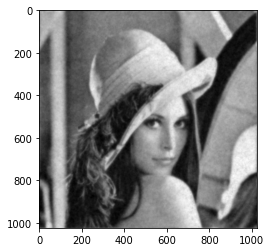

In [10]:
# TODO
fft_lena_shift_norm_transformed = shift2center*transform_matrix
f_ishift = np.fft.ifftshift(fft_lena_shift_norm_transformed)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)
plt.imshow(img_back, cmap='gray')
plt.show()

## Q2: 图像去模糊
使用维纳滤波进行图像去模糊

### 1.添加运动模糊<br>
这里有两种方法添加模糊,任选其一即可：<br>
#### （1）方法一：<br>
使用cv2.getRotationMatrix2D函数获得旋转矩阵，调用cv2.warpAffine函数生成运动模糊核，调用cv2.filter2D进行滤波获得模糊图像。<br>
#### （2）方法二：<br>
直接构造变换矩阵，这里提供了一个参考函数get_motion_psf：第一个参数是个元组，传递图像的尺寸；第二个参数为旋转的角度；第三个参数为偏移的像素数

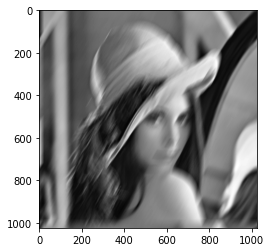

In [11]:
# TODO
def make_blurred(input, PSF, eps):
    input_fft = fft.fft2(input)
    PSF_fft = fft.fft2(PSF) + eps
    blurred = fft.ifft2(input_fft * PSF_fft)
    return np.uint8(np.abs(fft.ifftshift(blurred)))

PSF = get_motion_psf(img.shape, 60, 50)
blurred = make_blurred(img, PSF, 1e-3)
plt.imshow(blurred, cmap='gray')
plt.show()

### 2.添加高斯噪声，展示加噪模糊图<br>
方法同Q1

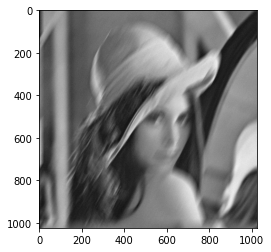

In [12]:
# TODO
blurred_noisy, noise = gaussian_noise(blurred, mean, 0.02)
plt.imshow(blurred_noisy, cmap='gray')
plt.show()

### 3.维纳滤波，展示恢复图<br>
（1）针对1中的方法一，需要将运动模糊核扩展成与原图大小相同的尺寸进行计算，在matlab中有现成的psf2otf函数可以调用，在opencv中没有需要自己实现，在Function.py中有一份可参考的psf2otf函数，请谨慎使用。<br>
（2）针对1中的方法二，实现就简单多了，因为所得的变换矩阵是全尺寸的。<br>
（3）随着在求得的频域OTF中可能存在模长很小的值，并在计算中出现在分母，请思考如何解决并回答。<br>
（4）这里假设之前的噪声添加是未知的，因此频域上每个点的SNR可以通过假设为同一个值进行计算。尝试不同的SNR，观察对比结果。<br>
（5）恢复的图像是否出现了振铃现象？为什么？

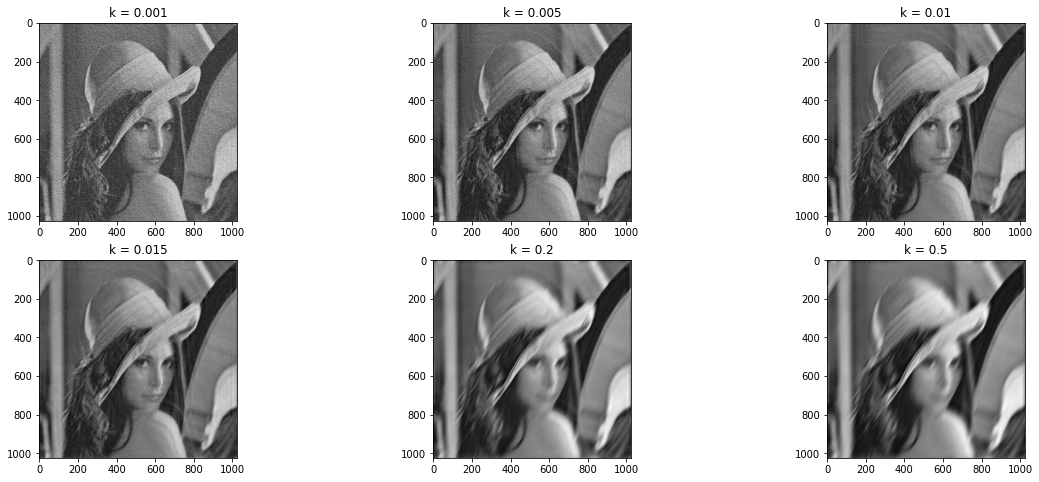

In [13]:
# TODO
def normal(image):
    image = np.where(image<0,0,image)
    image = np.where(image>255,255,image)
    return image

def winner(input, PSF, eps, K=0.01):
    input_fft = fft.fft2(input)
    PSF_fft = fft.fft2(PSF) + eps
    PSF_fft_1 = np.conj(PSF_fft)/(PSF_fft* np.conj(PSF_fft) + K)
    result = fft.ifft2(input_fft* PSF_fft_1)
    return normal(np.abs(fft.ifftshift(result))), np.abs((PSF_fft_1))

K_list = [0.001, 0.005, 0.01, 0.015, 0.2, 0.5]
figs, axes = plt.subplots(2,3, figsize=(20, 8))
axes = axes.flatten()
for axe, k in zip(axes, K_list):
    axe.imshow(normal(winner(blurred_noisy, PSF, 1e-3, k)[0]), cmap='gray')
    axe.set_title("k = {}".format(k))

plt.show()

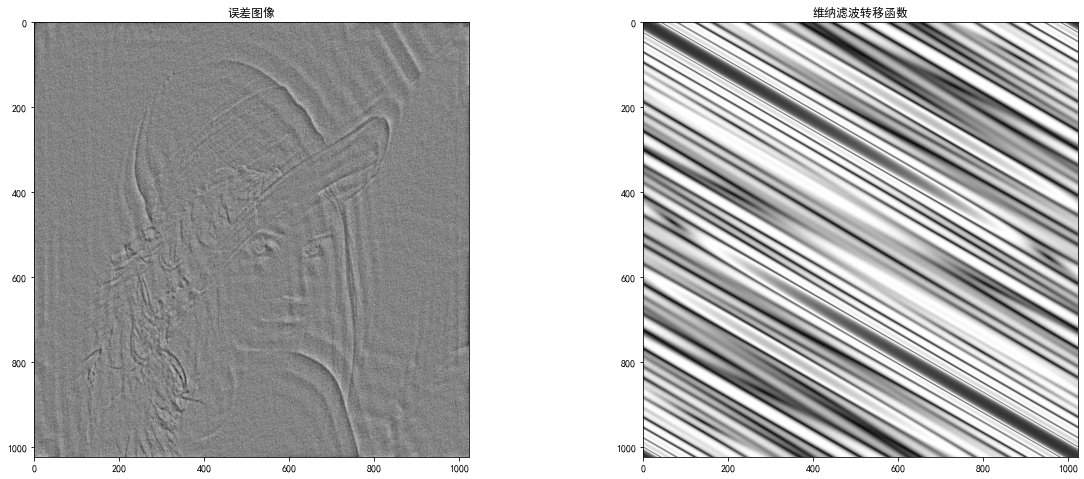

In [14]:
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']
figs, axes= plt.subplots(1,2, figsize = (20, 8))
axes = axes.flatten()
axes[0].set_title("误差图像")
axes[0].imshow(normal(winner(blurred_noisy, PSF, 1e-3, 0.01)[0]) - img, cmap='gray')
axes[1].set_title("维纳滤波转移函数")
axes[1].imshow(normal(winner(blurred_noisy, PSF, 1e-3, 0.01)[1]), cmap='gray')
plt.show()

（3）将滤波器频率限制在H(u,v)接近原点及其附近。因为H(0,0)附近通常是频率域中H(u,v)的最大值，H(u,v)的模长最大，使得N(u,v)/H(u,v)不会对F(u,v)产生太大影响。

（4）随着K值的增大，维纳滤波去除运动模糊的能力先增强后减弱，在k=0.010和k=0.015处滤波效果明显。

（5）出现了振铃现象，从误差图像中可以看出。从维纳滤波转移函数的图像可以看出，频域滤波函数具有陡峭变化，因此傅里叶逆变换得到的空域滤波函数会出现震荡。